# CE49X: Introduction to Computational Thinking and Data Science for Civil Engineers
## Week 3: NumPy and Pandas — Working with Real Data

**Instructor:** Dr. Eyuphan Koc  
**Department of Civil Engineering, Bogazici University**  
**Semester:** Spring 2026

---

## Istanbul Traffic: When and Where Does the City Grind to a Halt?

Istanbul ranks among the **world's most congested cities**. Three bridges span the Bosphorus — connecting Europe and Asia — and millions of vehicles cross them daily. The Istanbul Metropolitan Municipality (IBB) operates hundreds of traffic sensors across the city, recording speed and vehicle counts **every hour**.

We have **one week of real sensor data** — over **75,000 measurements** from October 2024.

**Our mission:** Can we find *when* and *where* Istanbul's traffic is worst? Which Bosphorus bridge suffers the most?

> **The Three Bosphorus Bridges:**
> - **15 July Martyrs Bridge** (1973) — the original, connecting Ortaköy to Beylerbeyi
> - **Fatih Sultan Mehmet Bridge** (1988) — the "second bridge," ~5 km north
> - **Yavuz Sultan Selim Bridge** (2016) — the newest, near the Black Sea entrance

### Roadmap

| Part | Tool | Engineering Question |
|------|------|---------------------|
| 1 | NumPy: Arrays | How do we represent 75K speed measurements efficiently? |
| 2 | NumPy: Operations | Can we compute speed ranges for ALL sensors at once? |
| 3 | NumPy: Analysis | Which locations have the slowest traffic? When? |
| 4 | Pandas: DataFrames | How do we work with timestamps and labeled columns? |
| 5 | Pandas: Indexing | Find all rush-hour measurements near the Bosphorus bridges |
| 6 | Pandas: Operations | Handle missing sensor data, group by hour and location |
| 7 | Integration | Full picture — Istanbul's traffic story in NumPy + Pandas |

---
## Part 1: NumPy Arrays — Speed Data as Arrays

Every hour, each sensor records a minimum speed, maximum speed, average speed, and vehicle count. That's **75,000 rows × 8 columns** of numbers. Can Python lists handle this?

Let's find out.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

%matplotlib inline

### Why NumPy? A Speed Test

Let's simulate computing the **speed range** (max − min) for 1 million sensor readings using pure Python lists vs NumPy arrays.

In [2]:
# Speed comparison: Python lists vs NumPy arrays
n = 1_000_000

# Python lists
min_list = list(range(10, n + 10))
max_list = list(range(50, n + 50))

start = time.time()
range_list = [mx - mn for mx, mn in zip(max_list, min_list)]
list_time = time.time() - start

# NumPy arrays
min_arr = np.arange(10, n + 10)
max_arr = np.arange(50, n + 50)

start = time.time()
range_arr = max_arr - min_arr
numpy_time = time.time() - start

print(f"Python lists: {list_time:.4f} seconds")
print(f"NumPy arrays: {numpy_time:.4f} seconds")
print(f"NumPy is {list_time / numpy_time:.0f}x faster!")

Python lists: 0.0251 seconds
NumPy arrays: 0.0022 seconds
NumPy is 11x faster!


### Creating Arrays from Traffic Data

Let's start small — average speeds from 5 sensors during one hour:

In [3]:
# Average speeds (km/h) from 5 sensors in one hour
speeds = np.array([42, 67, 15, 88, 33])
print("Speeds:", speeds)
print(f"Type: {type(speeds)}")

# Array attributes — the essential four
print(f"ndim:  {speeds.ndim}")    # dimensions
print(f"shape: {speeds.shape}")   # size along each dimension
print(f"size:  {speeds.size}")    # total elements
print(f"dtype: {speeds.dtype}")   # data type

Speeds: [42 67 15 88 33]
Type: <class 'numpy.ndarray'>
ndim:  1
shape: (5,)
size:  5
dtype: int64


### 2D Arrays: Sensors × Hours

Traffic data is naturally two-dimensional — multiple **sensors** measured across multiple **hours**. Each row is a sensor, each column is an hour.

In [4]:
# 4 sensors × 6 hours of average speed data
speed_matrix = np.array([
    [45, 38, 22, 15, 28, 52],  # Sensor A (near 15 July Bridge)
    [62, 55, 40, 32, 45, 68],  # Sensor B (highway)
    [35, 28, 18, 12, 22, 40],  # Sensor C (near FSM Bridge)
    [78, 72, 65, 58, 70, 82],  # Sensor D (suburban road)
])

print(f"Shape: {speed_matrix.shape}")  # (4 sensors, 6 hours)
print(f"Size: {speed_matrix.size} total readings\n")

# Indexing: row = sensor, column = hour
print(f"Sensor A, hour 3: {speed_matrix[0, 3]} km/h")
print(f"All sensors, hour 3 (rush hour): {speed_matrix[:, 3]}")
print(f"Sensor C, all hours: {speed_matrix[2, :]}")

Shape: (4, 6)
Size: 24 total readings

Sensor A, hour 3: 15 km/h
All sensors, hour 3 (rush hour): [15 32 12 58]
Sensor C, all hours: [35 28 18 12 22 40]


### Data Types and Array Creation

Speed data is always integers (km/h), but coordinates need floating point:

In [5]:
# Integer speeds
speeds_int = np.array([42, 67, 15], dtype=np.int32)
print(f"Speeds dtype: {speeds_int.dtype}, bytes per element: {speeds_int.itemsize}")

# Float coordinates
coords = np.array([41.045, 29.034, 41.090, 29.060], dtype=np.float64)
print(f"Coords dtype: {coords.dtype}, bytes per element: {coords.itemsize}")

# Useful creation functions
hours = np.arange(0, 24)           # 0 to 23 (hours of the day)
speed_bins = np.linspace(0, 150, 6) # 6 evenly spaced speed thresholds
no_data = np.zeros((3, 24))         # 3 sensors × 24 hours, initialized to 0

print(f"\nHours: {hours}")
print(f"Speed bins: {speed_bins}")
print(f"Sensor template shape: {no_data.shape}")

Speeds dtype: int32, bytes per element: 4
Coords dtype: float64, bytes per element: 8

Hours: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Speed bins: [  0.  30.  60.  90. 120. 150.]
Sensor template shape: (3, 24)


### Views vs Copies — An Important Distinction

When you slice a NumPy array, you get a **view** — it shares memory with the original. Modifying the view modifies the original!

In [6]:
# Views share memory
morning_speeds = speed_matrix[:, :3]  # first 3 hours
print("Morning (view):", morning_speeds[0])

morning_speeds[0, 0] = 999  # modifying the view...
print("Original changed too!", speed_matrix[0, :3])

# Reset
speed_matrix[0, 0] = 45

# Copies are independent
morning_copy = speed_matrix[:, :3].copy()
morning_copy[0, 0] = 999
print("\nOriginal unchanged:", speed_matrix[0, :3])

Morning (view): [45 38 22]
Original changed too! [999  38  22]

Original unchanged: [45 38 22]


### Reshaping and Combining Arrays

Morning and afternoon data might arrive separately — we need to combine them:

In [7]:
# Morning data (4 sensors × 3 hours) and afternoon data
morning = speed_matrix[:, :3]
afternoon = speed_matrix[:, 3:]

# Combine horizontally (more hours)
full_day = np.hstack([morning, afternoon])
print(f"Combined: {full_day.shape}")

# Stack two days vertically (more sensors/measurements)
day1 = np.array([[45, 38, 22], [62, 55, 40]])
day2 = np.array([[48, 35, 20], [65, 52, 38]])
two_days = np.vstack([day1, day2])
print(f"Two days stacked: {two_days.shape}")

# Reshape: flatten a 2D matrix into 1D for histograms
all_speeds = speed_matrix.reshape(-1)
print(f"Flattened: {all_speeds.shape} — {all_speeds}")

Combined: (4, 6)
Two days stacked: (4, 3)
Flattened: (24,) — [45 38 22 15 28 52 62 55 40 32 45 68 35 28 18 12 22 40 78 72 65 58 70 82]


> **Key Insight:** NumPy arrays store homogeneous data in contiguous memory blocks. This makes them *fast* to compute on but requires all elements to share a data type. For 75,000 traffic readings, this speed advantage is critical.

**Next:** We have arrays. But computing on them *one element at a time* defeats the purpose. Enter **vectorized operations**.

---
## Part 2: NumPy Operations — Vectorized Speed Analysis

The real power of NumPy: operate on **entire arrays at once** — no loops needed.

### Vectorized Arithmetic

Every sensor records minimum and maximum speed. The **speed range** tells us how variable traffic is — a large range means stop-and-go conditions:

In [8]:
# Sample data: 6 sensors
min_speed = np.array([5, 12, 30, 8, 45, 20])
max_speed = np.array([48, 65, 82, 55, 95, 70])
avg_speed = np.array([25, 38, 55, 30, 68, 42])

# Vectorized operations — all sensors at once
speed_range = max_speed - min_speed
congestion_ratio = avg_speed / max_speed  # closer to 1 = free flow

print("Speed ranges:", speed_range)
print("Congestion ratios:", np.round(congestion_ratio, 2))
print(f"\nMost variable sensor: #{np.argmax(speed_range)} (range = {speed_range.max()} km/h)")
print(f"Most congested sensor: #{np.argmin(congestion_ratio)} (ratio = {congestion_ratio.min():.2f})")

Speed ranges: [43 53 52 47 50 50]
Congestion ratios: [0.52 0.58 0.67 0.55 0.72 0.6 ]

Most variable sensor: #1 (range = 53 km/h)
Most congested sensor: #0 (ratio = 0.52)


### Broadcasting: Making Mismatched Shapes Work

What if we want to **normalize** each sensor's hourly readings by its daily maximum? The shapes don't match — but NumPy handles it automatically through **broadcasting**.

In [9]:
# 4 sensors × 6 hours
print("Speed matrix shape:", speed_matrix.shape)

# Maximum speed for each sensor (across all hours)
sensor_max = speed_matrix.max(axis=1)  # shape: (4,)
print("Sensor maxima:", sensor_max)

# Normalize: divide each row by its maximum
# Need shape (4,1) to broadcast against (4,6)
normalized = speed_matrix / sensor_max[:, np.newaxis]
print(f"\nNormalized shape: {normalized.shape}")
print("Sensor A normalized:", np.round(normalized[0], 2))
print("  → Rush hour (col 3) is only {:.0%} of free-flow speed".format(normalized[0, 3]))

Speed matrix shape: (4, 6)
Sensor maxima: [52 68 40 82]

Normalized shape: (4, 6)
Sensor A normalized: [0.87 0.73 0.42 0.29 0.54 1.  ]
  → Rush hour (col 3) is only 29% of free-flow speed


### Broadcasting for Distance: How Far Apart Are Sensors?

Given sensor latitudes and longitudes, we can compute a **pairwise distance matrix** using broadcasting — no loops needed.

In [10]:
# Sensor locations (latitude, longitude) for 4 sensors
lats = np.array([41.045, 41.090, 41.055, 41.205])
lons = np.array([29.034, 29.060, 29.045, 29.115])

# Approximate distance in km using Euclidean on lat/lon
# (1 degree lat ≈ 111 km, 1 degree lon ≈ 85 km at Istanbul's latitude)
KM_PER_LAT = 111.0
KM_PER_LON = 85.0

# Broadcasting: shape (4,1) - (1,4) → (4,4) pairwise differences
dlat = (lats[:, np.newaxis] - lats[np.newaxis, :]) * KM_PER_LAT
dlon = (lons[:, np.newaxis] - lons[np.newaxis, :]) * KM_PER_LON
distances = np.sqrt(dlat**2 + dlon**2)

print("Pairwise distances (km):")
print(np.round(distances, 1))
print(f"\nFarthest pair: {distances.max():.1f} km")

Pairwise distances (km):
[[ 0.   5.5  1.5 19. ]
 [ 5.5  0.   4.1 13.6]
 [ 1.5  4.1  0.  17.7]
 [19.  13.6 17.7  0. ]]

Farthest pair: 19.0 km


> **Key Insight:** Vectorized operations replace Python loops with optimized C code under the hood. Broadcasting extends this to arrays of different shapes — essential for normalizing data and computing pairwise relationships.

**Next:** Let's load the *real* 75,000-row dataset and use these tools to **find congestion patterns**.

---
## Part 3: NumPy Analysis — Finding Congestion Patterns

Time to work with the **real dataset**. We'll load it as NumPy arrays and use aggregation and boolean masking to find congestion patterns.

In [11]:
# Load the Istanbul traffic data
# We'll use np.genfromtxt to load specific numeric columns
import csv

# Read CSV and extract numeric columns as NumPy arrays
with open('istanbul_traffic_week.csv', 'r') as f:
    reader = csv.reader(f)
    header = next(reader)
    rows = list(reader)

# Extract columns as arrays
lat = np.array([float(r[1]) for r in rows])
lon = np.array([float(r[2]) for r in rows])
min_speed = np.array([int(r[4]) for r in rows])
max_speed = np.array([int(r[5]) for r in rows])
avg_speed = np.array([int(r[6]) for r in rows])
n_vehicles = np.array([int(r[7]) for r in rows])

print(f"Loaded {len(avg_speed):,} traffic measurements")
print(f"Columns: {header}")

Loaded 75,000 traffic measurements


Columns: ['DATE_TIME', 'LATITUDE', 'LONGITUDE', 'GEOHASH', 'MINIMUM_SPEED', 'MAXIMUM_SPEED', 'AVERAGE_SPEED', 'NUMBER_OF_VEHICLES']


### Aggregation Functions: Summarizing 75K Measurements

In [12]:
# Global statistics
print("=== Average Speed (km/h) ===")
print(f"  Mean:   {np.mean(avg_speed):.1f}")
print(f"  Median: {np.median(avg_speed):.1f}")
print(f"  Std:    {np.std(avg_speed):.1f}")
print(f"  Min:    {np.min(avg_speed)}")
print(f"  Max:    {np.max(avg_speed)}")

print(f"\n=== Vehicle Count ===")
print(f"  Mean:   {np.mean(n_vehicles):.0f}")
print(f"  Max:    {np.max(n_vehicles):,}")
print(f"  Total vehicle-readings: {np.sum(n_vehicles):,}")

=== Average Speed (km/h) ===
  Mean:   53.2
  Median: 47.0
  Std:    26.5
  Min:    3
  Max:    146

=== Vehicle Count ===
  Mean:   106
  Max:    1,644
  Total vehicle-readings: 7,955,674


### Boolean Masking: Finding Congested Sensors

A boolean mask is an array of `True`/`False` values — the same shape as the data. We can use it to **select only the rows that match a condition**.

In [13]:
# Boolean mask: where is average speed below 20 km/h?
congested = avg_speed < 20
print(f"Congested readings (< 20 km/h): {np.sum(congested):,} out of {len(avg_speed):,}")
print(f"That's {np.mean(congested):.1%} of all measurements")

# Extract the actual speed values
congested_speeds = avg_speed[congested]
print(f"\nMean speed when congested: {np.mean(congested_speeds):.1f} km/h")

# Compound conditions: severe congestion WITH high traffic volume
severe = (avg_speed < 15) & (n_vehicles > 50)
print(f"\nSevere congestion (speed < 15 & vehicles > 50): {np.sum(severe):,} readings")

Congested readings (< 20 km/h): 3,599 out of 75,000
That's 4.8% of all measurements

Mean speed when congested: 16.8 km/h

Severe congestion (speed < 15 & vehicles > 50): 209 readings


In [14]:
# Compute speed range for all 75K readings — vectorized!
speed_range = max_speed - min_speed

print(f"Speed range statistics:")
print(f"  Mean range: {np.mean(speed_range):.1f} km/h")
print(f"  Max range:  {np.max(speed_range)} km/h")

# Where is traffic most variable?
high_variability = speed_range > 100
print(f"\nHighly variable (range > 100 km/h): {np.sum(high_variability):,} readings")
print(f"Average vehicles at those locations: {np.mean(n_vehicles[high_variability]):.0f}")

Speed range statistics:
  Mean range: 77.0 km/h
  Max range:  221 km/h

Highly variable (range > 100 km/h): 18,936 readings
Average vehicles at those locations: 216


### Vehicle Count vs Speed: The Fundamental Relationship

More vehicles → slower speeds? Let's visualize with a quick scatter plot:

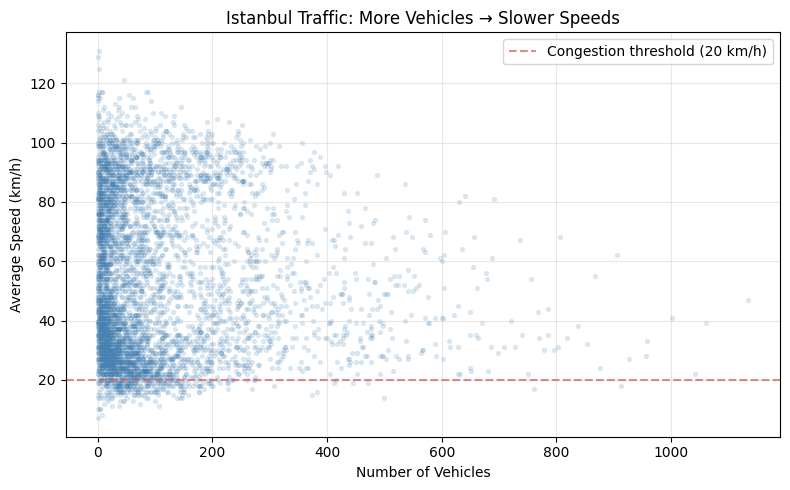

In [15]:
# [TOGETHER] Quick scatter: vehicle count vs average speed
fig, ax = plt.subplots(figsize=(8, 5))

# Sample 5000 points for a readable scatter
np.random.seed(42)
idx = np.random.choice(len(avg_speed), 5000, replace=False)

ax.scatter(n_vehicles[idx], avg_speed[idx], alpha=0.15, s=8, color='steelblue')
ax.set_xlabel('Number of Vehicles')
ax.set_ylabel('Average Speed (km/h)')
ax.set_title('Istanbul Traffic: More Vehicles → Slower Speeds')
ax.grid(True, alpha=0.3)

# Add a reference line
ax.axhline(y=20, color='indianred', linestyle='--', alpha=0.7, label='Congestion threshold (20 km/h)')
ax.legend()
plt.tight_layout()
plt.show()

In [16]:
# Find THE single worst measurement
worst_idx = np.argmin(avg_speed)
print(f"Worst congestion reading (index {worst_idx}):")
print(f"  Average speed: {avg_speed[worst_idx]} km/h")
print(f"  Speed range: {min_speed[worst_idx]}–{max_speed[worst_idx]} km/h")
print(f"  Vehicles: {n_vehicles[worst_idx]}")
print(f"  Location: ({lat[worst_idx]:.4f}, {lon[worst_idx]:.4f})")

Worst congestion reading (index 63052):
  Average speed: 3 km/h
  Speed range: 3–3 km/h
  Vehicles: 1
  Location: (41.0806, 28.7128)


> **Key Insight:** Boolean masking lets us ask complex questions of large datasets without loops: "show me all readings where speed is below 20 AND vehicles exceed 50." Combined with aggregation functions, we can summarize 75,000 measurements in milliseconds.

**But notice the problem:** `avg_speed[worst_idx]` tells us the speed, but *when* did this happen? We lost the timestamp because NumPy only stores numbers. We need **labels**. Enter Pandas.

---
## Part 4: Pandas DataFrames — Labeled Traffic Data

NumPy is fast but **label-blind** — column 6 could be speed or vehicle count. Pandas adds **labeled rows and columns**, making data analysis readable and less error-prone.

| Feature | NumPy | Pandas |
|---------|-------|--------|
| Data type | Homogeneous (one dtype) | Heterogeneous (mixed types per column) |
| Access | By position: `data[0, 3]` | By label: `df.loc['sensor_A', 'speed']` |
| Missing data | No built-in support | NaN with methods (dropna, fillna) |
| Best for | Fast numerical computation | Data wrangling, exploration, I/O |

In [17]:
# Load the full dataset with Pandas — one line!
df = pd.read_csv('istanbul_traffic_week.csv')

print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}\n")
df.head()

Shape: (75000, 8)
Columns: ['DATE_TIME', 'LATITUDE', 'LONGITUDE', 'GEOHASH', 'MINIMUM_SPEED', 'MAXIMUM_SPEED', 'AVERAGE_SPEED', 'NUMBER_OF_VEHICLES']



,DATE_TIME,LATITUDE,LONGITUDE,GEOHASH,MINIMUM_SPEED,MAXIMUM_SPEED,AVERAGE_SPEED,NUMBER_OF_VEHICLES
0,2024-10-01 00:00:00,41.119080,29.042358,sxk9uv,49,67,59,3
1,2024-10-01 00:00:00,41.064148,29.064331,sxk9t7,8,48,27,6
2,2024-10-01 00:00:00,41.091614,29.031372,sxk9u8,10,149,77,180
3,2024-10-01 00:00:00,41.108093,29.086304,sxk9vg,2,60,39,12
4,2024-10-01 00:00:00,41.113586,29.042358,sxk9uu,7,88,46,16


In [18]:
# Quick dataset overview
print(df.info())
print("\n" + "="*50)
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   DATE_TIME           75000 non-null  object 
 1   LATITUDE            75000 non-null  float64
 2   LONGITUDE           75000 non-null  float64
 3   GEOHASH             75000 non-null  object 
 4   MINIMUM_SPEED       75000 non-null  int64  
 5   MAXIMUM_SPEED       75000 non-null  int64  
 6   AVERAGE_SPEED       75000 non-null  int64  
 7   NUMBER_OF_VEHICLES  75000 non-null  int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 4.6+ MB


None



           LATITUDE     LONGITUDE  MINIMUM_SPEED  MAXIMUM_SPEED  \
count  75000.000000  75000.000000   75000.000000   75000.000000   
mean      41.067117     28.924140      20.839480      97.792240   
std        0.092937      0.323178      23.864023      38.636108   
min       40.767517     27.965698       1.000000       3.000000   
25%       41.014709     28.789673       3.000000      65.000000   
50%       41.064148     29.031372       8.000000      94.000000   
75%       41.119080     29.108276      36.000000     127.000000   
max       41.344299     29.635620     145.000000     245.000000   

       AVERAGE_SPEED  NUMBER_OF_VEHICLES  
count   75000.000000        75000.000000  
mean       53.198173          106.075653  
std        26.542711          136.043614  
min         3.000000            1.000000  
25%        30.000000           19.000000  
50%        47.000000           55.000000  
75%        77.000000          137.000000  
max       146.000000         1644.000000  


### Parsing Timestamps: Unlocking Time-Based Analysis

The `DATE_TIME` column is currently a string. Converting it to a proper datetime unlocks powerful time-based operations:

In [19]:
# Parse DATE_TIME and extract useful time components
df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'])
df['Hour'] = df['DATE_TIME'].dt.hour
df['Day_Name'] = df['DATE_TIME'].dt.day_name()
df['Day_of_Week'] = df['DATE_TIME'].dt.dayofweek  # 0=Monday, 6=Sunday

print("New columns added:")
print(df[['DATE_TIME', 'Hour', 'Day_Name', 'Day_of_Week']].head(8))

New columns added:
   DATE_TIME  Hour Day_Name  Day_of_Week
0 2024-10-01     0  Tuesday            1
1 2024-10-01     0  Tuesday            1
2 2024-10-01     0  Tuesday            1
3 2024-10-01     0  Tuesday            1
4 2024-10-01     0  Tuesday            1
5 2024-10-01     0  Tuesday            1
6 2024-10-01     0  Tuesday            1
7 2024-10-01     0  Tuesday            1


### Series: A Single Labeled Column

Each column of a DataFrame is a **Series** — a 1D array with an index:

In [20]:
# Extract a Series
speeds = df['AVERAGE_SPEED']
print(f"Type: {type(speeds)}")
print(f"Shape: {speeds.shape}")
print(f"dtype: {speeds.dtype}")
print(f"Mean: {speeds.mean():.1f} km/h\n")

# Series from a dict (creating our own)
bridge_speeds = pd.Series(
    {'15 July Martyrs': 28, 'FSM': 35, 'Yavuz Sultan Selim': 62},
    name='avg_speed_kmh'
)
print(bridge_speeds)

Type: <class 'pandas.core.series.Series'>
Shape: (75000,)
dtype: int64
Mean: 53.2 km/h

15 July Martyrs       28
FSM                   35
Yavuz Sultan Selim    62
Name: avg_speed_kmh, dtype: int64


### Adding Computed Columns

Just like NumPy vectorized operations, Pandas lets us create new columns from existing ones:

In [21]:
# Compute new columns — vectorized, just like NumPy
df['Speed_Range'] = df['MAXIMUM_SPEED'] - df['MINIMUM_SPEED']
df['Congestion_Ratio'] = df['AVERAGE_SPEED'] / df['MAXIMUM_SPEED']

print("New columns:")
print(df[['AVERAGE_SPEED', 'MAXIMUM_SPEED', 'Speed_Range', 'Congestion_Ratio']].head())
print(f"\nMean speed range: {df['Speed_Range'].mean():.1f} km/h")
print(f"Mean congestion ratio: {df['Congestion_Ratio'].mean():.2f}")

New columns:
   AVERAGE_SPEED  MAXIMUM_SPEED  Speed_Range  Congestion_Ratio
0             59             67           18          0.880597
1             27             48           40          0.562500
2             77            149          139          0.516779
3             39             60           58          0.650000
4             46             88           81          0.522727

Mean speed range: 77.0 km/h
Mean congestion ratio: 0.54


In [22]:
# [PRACTICE] Creating a DataFrame from NumPy arrays (connecting back to Part 1)
# Remember our speed_matrix from Part 1?
sensor_names = ['Bridge_A', 'Highway_B', 'Bridge_C', 'Suburb_D']
hour_labels = ['6am', '7am', '8am', '9am', '10am', '11am']

speed_df = pd.DataFrame(
    speed_matrix,
    index=sensor_names,
    columns=hour_labels
)
print("DataFrame from NumPy array:")
print(speed_df)
print(f"\nUnderlying NumPy array dtype: {speed_df.values.dtype}")

DataFrame from NumPy array:
           6am  7am  8am  9am  10am  11am
Bridge_A    45   38   22   15    28    52
Highway_B   62   55   40   32    45    68
Bridge_C    35   28   18   12    22    40
Suburb_D    78   72   65   58    70    82

Underlying NumPy array dtype: int64


> **Key Insight:** Pandas wraps NumPy arrays with labels (column names, row indices) and adds powerful I/O, datetime parsing, and missing data support. Use NumPy when you need pure speed on numeric arrays; use Pandas when you need structure and labels.

**Next:** We have labeled data. Now let's use Pandas' powerful **indexing** to find exactly the rows we need.

---
## Part 5: Pandas Indexing & Filtering

### The Golden Rule

| Accessor | Based on | Example |
|----------|----------|---------|
| `df.loc[]` | **Labels** (row/column names) | `df.loc[0:5, 'AVERAGE_SPEED']` |
| `df.iloc[]` | **Integer positions** | `df.iloc[0:5, 6]` |
| `df[]` | **Columns** or **boolean masks** | `df['AVERAGE_SPEED']` or `df[df['Hour']==8]` |

In [23]:
# loc: label-based indexing
print("First 3 rows, specific columns (loc):")
print(df.loc[0:2, ['DATE_TIME', 'AVERAGE_SPEED', 'NUMBER_OF_VEHICLES']])

print("\n" + "="*50)

# iloc: integer position-based indexing
print("\nFirst 3 rows, columns 0 and 6 (iloc):")
print(df.iloc[0:3, [0, 6]])

First 3 rows, specific columns (loc):
   DATE_TIME  AVERAGE_SPEED  NUMBER_OF_VEHICLES
0 2024-10-01             59                   3
1 2024-10-01             27                   6
2 2024-10-01             77                 180


First 3 rows, columns 0 and 6 (iloc):
   DATE_TIME  AVERAGE_SPEED
0 2024-10-01             59
1 2024-10-01             27
2 2024-10-01             77


### Boolean Filtering: Finding Rush Hour Near the Bridges

This is where Pandas shines — combining readable column names with boolean logic:

In [24]:
# Define rush hours: 7-9 AM and 5-7 PM
morning_rush = df['Hour'].isin([7, 8, 9])
evening_rush = df['Hour'].isin([17, 18, 19])
rush_hour = morning_rush | evening_rush

# Define bridge area: approximate bounding box for Bosphorus bridges
# Latitude roughly 41.0 to 41.22, Longitude roughly 29.0 to 29.15
bridge_area = (
    (df['LATITUDE'] > 41.0) & (df['LATITUDE'] < 41.22) &
    (df['LONGITUDE'] > 29.0) & (df['LONGITUDE'] < 29.15)
)

# Combine: rush hour AND near bridges
bridge_rush = df[rush_hour & bridge_area]

print(f"Total measurements: {len(df):,}")
print(f"Rush hour measurements: {rush_hour.sum():,}")
print(f"Bridge area measurements: {bridge_area.sum():,}")
print(f"Rush hour + bridge area: {len(bridge_rush):,}")
print(f"\nAvg speed during bridge rush hour: {bridge_rush['AVERAGE_SPEED'].mean():.1f} km/h")
print(f"Avg speed overall: {df['AVERAGE_SPEED'].mean():.1f} km/h")

Total measurements: 75,000
Rush hour measurements: 19,066
Bridge area measurements: 23,189
Rush hour + bridge area: 5,895

Avg speed during bridge rush hour: 37.5 km/h
Avg speed overall: 53.2 km/h


In [25]:
# loc with boolean mask for precise column selection
worst_congestion = df.loc[
    (df['AVERAGE_SPEED'] < 15) & (df['NUMBER_OF_VEHICLES'] > 50),
    ['DATE_TIME', 'LATITUDE', 'LONGITUDE', 'AVERAGE_SPEED', 'NUMBER_OF_VEHICLES']
]

print(f"Severe congestion events (speed < 15, vehicles > 50): {len(worst_congestion)}")
print(worst_congestion.head(10))

Severe congestion events (speed < 15, vehicles > 50): 209
               DATE_TIME   LATITUDE  LONGITUDE  AVERAGE_SPEED  \
3671 2024-10-01 08:00:00  40.998230  28.789673             13   
3763 2024-10-01 08:00:00  40.998230  28.844604             13   
3900 2024-10-01 08:00:00  41.014709  28.855591             14   
4208 2024-10-01 09:00:00  41.042175  28.877563             14   
5524 2024-10-01 12:00:00  41.042175  28.877563             13   
5709 2024-10-01 12:00:00  41.014709  28.866577             14   
5974 2024-10-01 13:00:00  40.998230  28.833618             12   
6263 2024-10-01 14:00:00  41.097107  29.086304             14   
6586 2024-10-01 14:00:00  41.003723  28.800659             14   
6937 2024-10-01 15:00:00  41.091614  28.998413             11   

      NUMBER_OF_VEHICLES  
3671                 109  
3763                 125  
3900                 143  
4208                  59  
5524                  78  
5709                  91  
5974                  79  
6263      

In [26]:
# The 20 worst congestion points in the dataset
print("Top 20 worst congestion readings:\n")
worst_20 = df.nsmallest(20, 'AVERAGE_SPEED')[
    ['DATE_TIME', 'AVERAGE_SPEED', 'NUMBER_OF_VEHICLES', 'LATITUDE', 'LONGITUDE', 'Day_Name', 'Hour']
]
print(worst_20.to_string(index=False))

Top 20 worst congestion readings:

          DATE_TIME  AVERAGE_SPEED  NUMBER_OF_VEHICLES  LATITUDE  LONGITUDE  Day_Name  Hour
2024-10-06 21:00:00              3                   1 41.080627  28.712769    Sunday    21
2024-10-06 17:00:00              4                   1 41.036682  29.020386    Sunday    17
2024-10-05 20:00:00              5                   2 41.058655  29.042358  Saturday    20
2024-10-01 08:00:00              6                   7 41.108093  29.097290   Tuesday     8
2024-10-03 04:00:00              6                   1 40.882874  29.185181  Thursday     4
2024-10-03 12:00:00              6                   1 41.036682  29.020386  Thursday    12
2024-10-04 04:00:00              7                   1 40.954285  29.393921    Friday     4
2024-10-05 00:00:00              7                   4 41.058655  29.042358  Saturday     0
2024-10-07 04:00:00              7                   1 41.086121  29.064331    Monday     4
2024-10-01 18:00:00              8           

In [27]:
# Sort by multiple columns: slowest speeds first, then highest vehicle count
slow_busy = df.sort_values(
    ['AVERAGE_SPEED', 'NUMBER_OF_VEHICLES'],
    ascending=[True, False]
)
print("Slowest and busiest readings:")
print(slow_busy[['DATE_TIME', 'AVERAGE_SPEED', 'NUMBER_OF_VEHICLES', 'Day_Name']].head(10))

Slowest and busiest readings:
                DATE_TIME  AVERAGE_SPEED  NUMBER_OF_VEHICLES  Day_Name
63052 2024-10-06 21:00:00              3                   1    Sunday
61145 2024-10-06 17:00:00              4                   1    Sunday
51850 2024-10-05 20:00:00              5                   2  Saturday
3734  2024-10-01 08:00:00              6                   7   Tuesday
23427 2024-10-03 04:00:00              6                   1  Thursday
26748 2024-10-03 12:00:00              6                   1  Thursday
42808 2024-10-05 00:00:00              7                   4  Saturday
33878 2024-10-04 04:00:00              7                   1    Friday
65983 2024-10-07 04:00:00              7                   1    Monday
39791 2024-10-04 17:00:00              8                  24    Friday


> **Key Insight:** Boolean filtering with readable column names is one of Pandas' greatest strengths. Instead of remembering `data[:, 6] < 15`, we write `df['AVERAGE_SPEED'] < 15` — self-documenting and far less error-prone.

**Next:** Real sensor data is **messy** — sensors go offline, records have gaps. We also need to **group** data by time and location to see the big picture.

---
## Part 6: Pandas Operations — Missing Data & GroupBy

### Missing Data: When Sensors Go Offline

Traffic sensors can fail due to power outages, construction, or hardware issues. Let's simulate this reality:

In [28]:
# Simulate 5% sensor failures by setting random speed values to NaN
np.random.seed(42)
df_missing = df.copy()

# Randomly set 5% of AVERAGE_SPEED to NaN
mask = np.random.random(len(df_missing)) < 0.05
df_missing.loc[mask, 'AVERAGE_SPEED'] = np.nan
df_missing.loc[mask, 'MINIMUM_SPEED'] = np.nan
df_missing.loc[mask, 'MAXIMUM_SPEED'] = np.nan

print(f"Missing values per column:")
print(df_missing[['AVERAGE_SPEED', 'MINIMUM_SPEED', 'MAXIMUM_SPEED']].isnull().sum())
print(f"\nTotal rows: {len(df_missing):,}")
print(f"Rows with missing speed: {df_missing['AVERAGE_SPEED'].isnull().sum():,} ({mask.mean():.1%})")

Missing values per column:
AVERAGE_SPEED    3718
MINIMUM_SPEED    3718
MAXIMUM_SPEED    3718
dtype: int64

Total rows: 75,000
Rows with missing speed: 3,718 (5.0%)


### Three Strategies for Missing Data

In [29]:
# Strategy 1: Drop rows with missing values
dropped = df_missing.dropna(subset=['AVERAGE_SPEED'])
print(f"After dropna: {len(dropped):,} rows (lost {len(df_missing) - len(dropped):,})")

# Strategy 2: Fill with the column mean
mean_filled = df_missing['AVERAGE_SPEED'].fillna(df_missing['AVERAGE_SPEED'].mean())
print(f"Mean-filled mean: {mean_filled.mean():.1f} km/h (original: {df['AVERAGE_SPEED'].mean():.1f})")

# Strategy 3: Forward fill (good for time series — use last known value)
df_missing_sorted = df_missing.sort_values('DATE_TIME')
ffilled = df_missing_sorted['AVERAGE_SPEED'].ffill()
print(f"Forward-filled NaN count: {ffilled.isnull().sum()}")

# We'll use the original (complete) data for the rest of the analysis
print("\n→ For our analysis, we'll use the original complete dataset.")

After dropna: 71,282 rows (lost 3,718)
Mean-filled mean: 53.2 km/h (original: 53.2)
Forward-filled NaN count: 0

→ For our analysis, we'll use the original complete dataset.


### Index Alignment: Pandas Handles Mismatched Data

When combining two Series with different indices, Pandas automatically aligns by label:

In [30]:
# Two Series with different sensors
morning_avg = pd.Series({'A': 28, 'B': 45, 'C': 32, 'D': 55}, name='morning')
evening_avg = pd.Series({'A': 22, 'B': 38, 'C': 28, 'E': 60}, name='evening')

# Subtraction aligns by index — sensor D and E get NaN
speed_change = morning_avg - evening_avg
print("Speed change (morning - evening):")
print(speed_change)
print("\n→ Sensor D and E have NaN because they don't appear in both Series")

Speed change (morning - evening):
A    6.0
B    7.0
C    4.0
D    NaN
E    NaN
dtype: float64

→ Sensor D and E have NaN because they don't appear in both Series


### GroupBy: The Key to Understanding Traffic Patterns

GroupBy splits data into groups, applies a function, and combines results. This is how we answer: *"What's the average speed by hour of day?"*

In [31]:
# [TOGETHER] Average speed by hour of day
hourly = df.groupby('Hour')['AVERAGE_SPEED'].mean()

print("Average speed by hour of day:")
print(hourly.round(1))
print(f"\nSlowest hour: {hourly.idxmin()}:00 ({hourly.min():.1f} km/h)")
print(f"Fastest hour: {hourly.idxmax()}:00 ({hourly.max():.1f} km/h)")

Average speed by hour of day:
Hour
0     55.8
1     56.7
2     57.8
3     57.8
4     59.1
5     57.3
6     56.5
7     54.6
8     53.1
9     51.9
10    52.4
11    51.5
12    51.5
13    51.4
14    50.7
15    49.8
16    49.0
17    49.2
18    49.6
19    49.0
20    51.4
21    53.2
22    53.4
23    55.3
Name: AVERAGE_SPEED, dtype: float64

Slowest hour: 19:00 (49.0 km/h)
Fastest hour: 4:00 (59.1 km/h)


In [32]:
# Average speed by day of week
daily = df.groupby('Day_Name')['AVERAGE_SPEED'].mean()

# Reorder days properly
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily = daily.reindex(day_order)

print("Average speed by day:")
print(daily.round(1))

Average speed by day:
Day_Name
Monday       52.4
Tuesday      53.0
Wednesday    53.0
Thursday     53.1
Friday       52.6
Saturday     53.2
Sunday       55.0
Name: AVERAGE_SPEED, dtype: float64


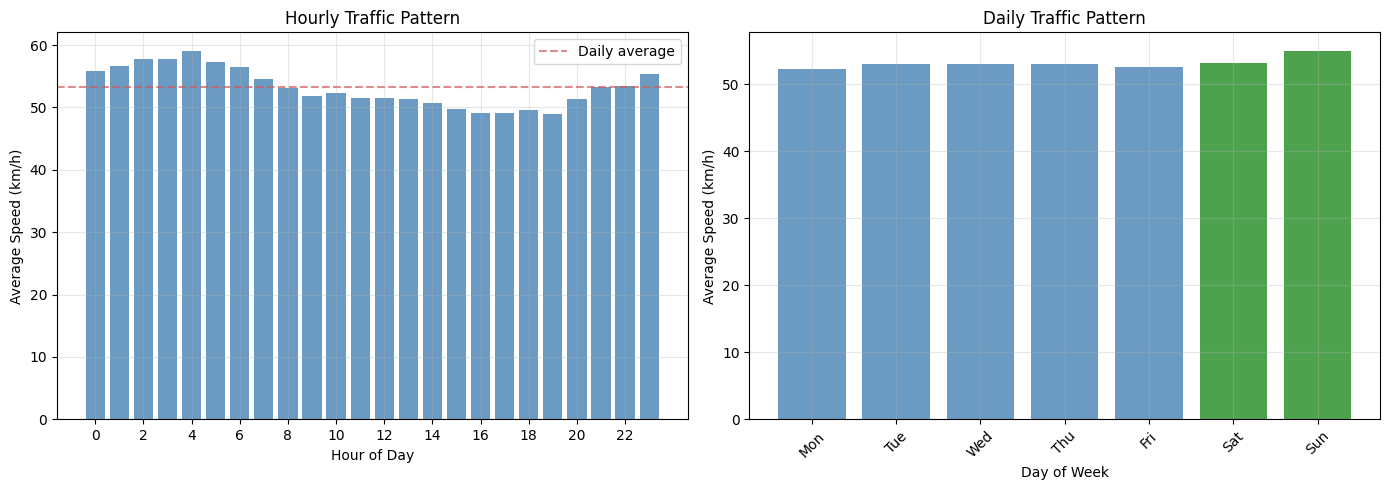

In [33]:
# Visualize hourly and daily patterns side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Hourly pattern
ax1.bar(hourly.index, hourly.values, color='steelblue', alpha=0.8)
ax1.axhline(y=hourly.mean(), color='indianred', linestyle='--', alpha=0.7, label='Daily average')
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Average Speed (km/h)')
ax1.set_title('Hourly Traffic Pattern')
ax1.set_xticks(range(0, 24, 2))
ax1.legend()
ax1.grid(True, alpha=0.3)

# Daily pattern
colors = ['steelblue'] * 5 + ['forestgreen'] * 2  # weekdays vs weekend
ax2.bar(range(7), daily.values, color=colors, alpha=0.8)
ax2.set_xlabel('Day of Week')
ax2.set_ylabel('Average Speed (km/h)')
ax2.set_title('Daily Traffic Pattern')
ax2.set_xticks(range(7))
ax2.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=45)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [34]:
# Busiest areas by geohash
busiest = df.groupby('GEOHASH').agg(
    avg_speed=('AVERAGE_SPEED', 'mean'),
    total_vehicles=('NUMBER_OF_VEHICLES', 'sum'),
    n_readings=('AVERAGE_SPEED', 'count')
).sort_values('total_vehicles', ascending=False)

print("Top 10 busiest sensor areas:")
print(busiest.head(10).round(1))

Top 10 busiest sensor areas:
         avg_speed  total_vehicles  n_readings
GEOHASH                                       
sxk9vb        54.6           79395         168
sxk9ub        61.4           69174         168
sxk9v0        69.7           62832         168
sxk9u8        58.3           62566         168
sxk9v8        67.0           61223         168
sxk9v2        69.8           59363         168
sxk9ku        37.2           57254         168
sxk9s5        38.7           53333         168
sxk9sh        36.6           50627         168
sxk9m5        45.2           45778         168


In [35]:
# Bin speeds into traffic categories
df['Traffic_Level'] = pd.cut(
    df['AVERAGE_SPEED'],
    bins=[0, 15, 30, 60, 200],
    labels=['Gridlock', 'Congested', 'Moderate', 'Free Flow']
)

# Distribution of traffic levels
level_counts = df['Traffic_Level'].value_counts()
print("Traffic level distribution:")
print(level_counts)
print(f"\n{level_counts['Gridlock'] / len(df):.1%} of readings are Gridlock")

Traffic level distribution:
Traffic_Level
Free Flow    28526
Moderate     26720
Congested    18918
Gridlock       836
Name: count, dtype: int64

1.1% of readings are Gridlock


> **Key Insight:** GroupBy is one of Pandas' most powerful operations. By grouping 75,000 measurements by hour, day, or location, we transform raw data into actionable patterns — like identifying rush hour peaks at 8 AM and 6 PM.

**Next:** Let's combine everything — NumPy speed + Pandas structure — to answer the big question: **which Bosphorus bridge has the worst traffic?**

---
## Part 7: Integration — Istanbul's Traffic Story

**The question:** Which of the three Bosphorus bridges has the worst rush-hour traffic?

We'll use:
- **NumPy** broadcasting to compute distances from each sensor to each bridge
- **Pandas** filtering and GroupBy to analyze traffic by bridge and time

In [36]:
# Approximate coordinates of the three Bosphorus bridges
bridges = {
    '15 July Martyrs': (41.047, 29.034),
    'FSM': (41.090, 29.056),
    'Yavuz Sultan Selim': (41.205, 29.110)
}

# Compute distance from each sensor to each bridge using NumPy broadcasting
sensor_lats = df['LATITUDE'].values
sensor_lons = df['LONGITUDE'].values

KM_PER_LAT = 111.0
KM_PER_LON = 85.0

# Classify each reading by nearest bridge (within 3 km) or 'Other'
df['Nearest_Bridge'] = 'Other'
df['Bridge_Distance_km'] = np.inf

for bridge_name, (blat, blon) in bridges.items():
    dlat = (sensor_lats - blat) * KM_PER_LAT
    dlon = (sensor_lons - blon) * KM_PER_LON
    dist = np.sqrt(dlat**2 + dlon**2)

    # Update nearest bridge where this bridge is closer
    closer = dist < df['Bridge_Distance_km']
    df.loc[closer, 'Nearest_Bridge'] = bridge_name
    df.loc[closer, 'Bridge_Distance_km'] = dist[closer]

# Only keep "near bridge" if within 3 km
df.loc[df['Bridge_Distance_km'] > 3.0, 'Nearest_Bridge'] = 'Other'

print("Sensors classified by nearest bridge:")
print(df['Nearest_Bridge'].value_counts())

Sensors classified by nearest bridge:


Nearest_Bridge
Other                 59282
FSM                    7329
15 July Martyrs        6541
Yavuz Sultan Selim     1848
Name: count, dtype: int64


In [37]:
# Filter to bridge-area sensors only
bridge_df = df[df['Nearest_Bridge'] != 'Other'].copy()
print(f"Bridge-area measurements: {len(bridge_df):,}\n")

# Average speed by bridge × hour
bridge_hourly = bridge_df.groupby(['Nearest_Bridge', 'Hour'])['AVERAGE_SPEED'].mean().unstack(level=0)
print("Average speed by bridge and hour (sample hours):")
print(bridge_hourly.loc[[7, 8, 9, 12, 17, 18, 19]].round(1))

Bridge-area measurements: 15,718

Average speed by bridge and hour (sample hours):
Nearest_Bridge  15 July Martyrs   FSM  Yavuz Sultan Selim
Hour                                                     
7                          35.7  39.1               102.5
8                          32.4  36.4               105.9
9                          31.7  36.1               102.6
12                         29.5  34.1                96.2
17                         26.1  29.9               103.4
18                         25.2  28.9               103.7
19                         27.1  29.8               101.4


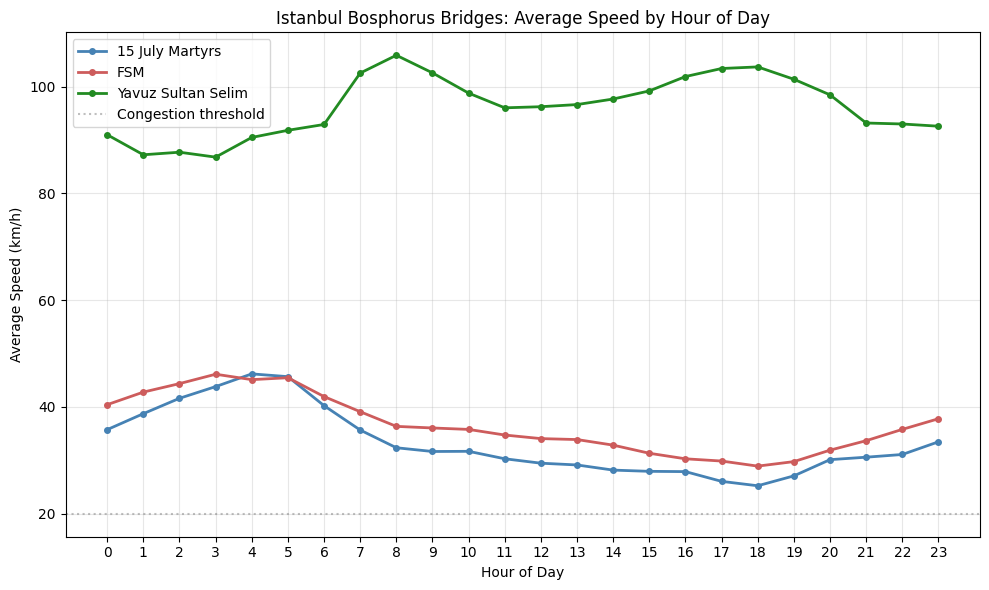

In [38]:
# [TOGETHER] The final plot: average speed by hour for each bridge
fig, ax = plt.subplots(figsize=(10, 6))

colors = {'15 July Martyrs': 'steelblue', 'FSM': 'indianred', 'Yavuz Sultan Selim': 'forestgreen'}

for bridge_name in bridges:
    if bridge_name in bridge_hourly.columns:
        ax.plot(
            bridge_hourly.index, bridge_hourly[bridge_name],
            marker='o', markersize=4, linewidth=2,
            color=colors[bridge_name], label=bridge_name
        )

ax.axhline(y=20, color='gray', linestyle=':', alpha=0.5, label='Congestion threshold')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Average Speed (km/h)')
ax.set_title('Istanbul Bosphorus Bridges: Average Speed by Hour of Day')
ax.set_xticks(range(0, 24))
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [39]:
# Summary: which bridge, which hour?
print("=" * 60)
print("ISTANBUL BOSPHORUS BRIDGE TRAFFIC ANALYSIS")
print("Data: October 1–7, 2024 (IBB Open Data)")
print("=" * 60)

for bridge_name in bridges:
    if bridge_name in bridge_hourly.columns:
        col = bridge_hourly[bridge_name]
        worst_hour = col.idxmin()
        worst_speed = col.min()
        n_readings = len(bridge_df[bridge_df['Nearest_Bridge'] == bridge_name])
        print(f"\n{bridge_name}:")
        print(f"  Readings: {n_readings:,}")
        print(f"  Overall avg speed: {col.mean():.1f} km/h")
        print(f"  Worst hour: {worst_hour}:00 ({worst_speed:.1f} km/h)")

# Overall winner (loser?)
all_bridge_means = bridge_df.groupby('Nearest_Bridge')['AVERAGE_SPEED'].mean()
worst_bridge = all_bridge_means.idxmin()
print(f"\n→ Most congested bridge overall: {worst_bridge} ({all_bridge_means[worst_bridge]:.1f} km/h avg)")

ISTANBUL BOSPHORUS BRIDGE TRAFFIC ANALYSIS
Data: October 1–7, 2024 (IBB Open Data)

15 July Martyrs:
  Readings: 6,541
  Overall avg speed: 33.3 km/h
  Worst hour: 18:00 (25.2 km/h)

FSM:
  Readings: 7,329
  Overall avg speed: 36.6 km/h
  Worst hour: 18:00 (28.9 km/h)

Yavuz Sultan Selim:
  Readings: 1,848
  Overall avg speed: 96.3 km/h
  Worst hour: 3:00 (86.8 km/h)

→ Most congested bridge overall: 15 July Martyrs (33.3 km/h avg)


> **Key Insight:** By combining NumPy's fast distance calculations with Pandas' GroupBy, we transformed 75,000 raw sensor readings into an actionable insight: which bridge is worst and when. This is the data science pipeline in action — from raw numbers to decisions.

---
## Recap: One City's Data, Two Powerful Libraries

| Part | Tool | What We Did | Key Concept |
|------|------|-------------|-------------|
| 1 | NumPy Arrays | Stored 75K speed readings | Array creation, shape, dtype |
| 2 | NumPy Operations | Speed ranges in one line | Vectorization, broadcasting |
| 3 | NumPy Analysis | Found congested sensors | Aggregations, boolean masking |
| 4 | Pandas DataFrames | Added labels, parsed timestamps | Series, DataFrame, read_csv |
| 5 | Pandas Indexing | Filtered rush hour at bridges | loc/iloc, boolean filtering |
| 6 | Pandas Operations | Handled missing sensors, grouped by hour | dropna, fillna, groupby |
| 7 | Integration | Identified worst bottlenecks by bridge | NumPy speed + Pandas structure |

> **Key Insight:** NumPy and Pandas are complementary — NumPy provides the fast numerical engine, Pandas wraps it with labels and data wrangling tools. Real-world data analysis almost always uses both.

### Quick Reference

```python
# NumPy essentials
import numpy as np
a = np.array([1, 2, 3])           # create array
a.shape, a.dtype, a.size           # attributes
a[a > 2]                           # boolean masking
np.mean(a), np.std(a)              # aggregations
a[:, np.newaxis]                   # add dimension for broadcasting

# Pandas essentials
import pandas as pd
df = pd.read_csv('file.csv')       # load data
df.head(), df.info(), df.describe() # explore
df['col']                           # select column (Series)
df.loc[mask, cols]                  # label-based selection
df.iloc[0:5, 2:4]                  # position-based selection
df[df['col'] > threshold]           # boolean filtering
df.groupby('col')['val'].mean()     # split-apply-combine
df['col'].fillna(value)             # handle missing data
pd.to_datetime(df['date_col'])      # parse timestamps
```

---

### Questions?

**Dr. Eyuphan Koc**  
eyuphan.koc@bogazici.edu.tr